# Explore FlatNet Gen

Date: 25th July 2020

In [2]:
# Install required packages
!pip install -r utils/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'utils/requirements.txt'


In [4]:
# Imports
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path

In [5]:
from models.fftlayer import fft_conv2d, get_wiener_matrix
from utils.ops import roll_n

class FFTLayer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        # Inference mode
        requires_grad = False

        psf = torch.tensor(np.load(args.psf_mat)).float()

        psf_crop_top = args.psf_centre_x - args.psf_crop_size_x // 2
        psf_crop_bottom = args.psf_centre_x + args.psf_crop_size_x // 2
        psf_crop_left = args.psf_centre_y - args.psf_crop_size_y // 2
        psf_crop_right = args.psf_centre_y + args.psf_crop_size_y // 2

        psf_crop = psf[psf_crop_top:psf_crop_bottom, psf_crop_left:psf_crop_right]

        wiener_crop = get_wiener_matrix(
            psf_crop, Gamma=args.fft_gamma, centre_roll=False
        )

        self.wiener_crop = nn.Parameter(wiener_crop, requires_grad=requires_grad)

        self.normalizer = nn.Parameter(
            torch.tensor([1 / 0.0008]).reshape(1, 1, 1, 1), requires_grad=requires_grad
        )

        if self.args.use_mask:
            mask = torch.tensor(np.load(args.mask_path)).float()
            self.mask = nn.Parameter(mask, requires_grad=False)

    def forward(self, img):
        img_h = self.args.image_height
        img_w = self.args.image_width

        pad_x = self.args.psf_height - self.args.psf_crop_size_x
        pad_y = self.args.psf_width - self.args.psf_crop_size_y

        # Pad to psf_height
        self.fft_layer = 1 * self.wiener_crop

        self.fft_layer = F.pad(
            self.fft_layer,
            (
                pad_y // 2,
                pad_y // 2,
                pad_x // 2,
                pad_x // 2,
            ),
        )

        # Centre roll
        for dim in range(2):
            self.fft_layer = roll_n(
                self.fft_layer, axis=dim, n=self.fft_layer.size(dim) // 2
            )

        self.fft_layer = self.fft_layer.unsqueeze(0).unsqueeze(0)

        _, _, fft_h, fft_w = self.fft_layer.shape

        # Convert to 0...1
        img = 0.5 * img + 0.5

        # Use mask
        if self.args.use_mask:
            img = img * self.mask

        # Do FFT convolve
        img = fft_conv2d(img, self.fft_layer) * self.normalizer

        # Centre Crop
        img = img[
              :,
              :,
              fft_h // 2 - img_h // 2: fft_h // 2 + img_h // 2,
              fft_w // 2 - img_w // 2: fft_w // 2 + img_w // 2,
              ]

        return img


In [8]:
from models.unet import Unet
from utils.model_serialization import load_state_dict

G = Unet(args)
FFT = FFTLayer(args)

#Specify path to the models. Trainable inversion is called FFTLayer here as it
#is implemented using FFT based learned deconvolution. Gen refers to the U-Net or perceptual enhancement stage.

# Ours
ckpt_dir = Path("ckpts_phase_mask_Feb_2020_size_384") / "ours-fft-1280-1408-learn-1280-1408-meas-1280-1408"
model_gen_path = ckpt_dir / "model_latest.pth"
model_fft_path = ckpt_dir / "FFT_latest.pth"

gen_ckpt = torch.load(model_gen_path, map_location=torch.device("cpu"))
fft_ckpt = torch.load(model_fft_path, map_location=torch.device("cpu"))

# G.load_state_dict(gen_ckpt["state_dict"])
load_state_dict(G, gen_ckpt["state_dict"])
load_state_dict(FFT, fft_ckpt["state_dict"])

device = args.device

G = G.to(device)
FFT = FFT.to(device)

In [15]:
import cv2

# Specify path to the measurement
meas_path = Path("data/phase_images/n02165456_10030.png")  

raw = cv2.imread(str(meas_path),-1) / 4096.0
raw_h, raw_w = raw.shape
img = np.zeros((raw_h // 2, raw_w // 2, 4))

img[:, :, 0] = raw[0::2, 0::2]  # r
img[:, :, 1] = raw[0::2, 1::2]  # gr
img[:, :, 2] = raw[1::2, 0::2]  # gb
img[:, :, 3] = raw[1::2, 1::2]  # b

img = torch.tensor(img)

# Crop
if args.meas_crop_size_x and args.meas_crop_size_y:
    crop_x = args.meas_centre_x - args.meas_crop_size_x // 2
    crop_y = args.meas_centre_y - args.meas_crop_size_y // 2

    # Replicate padding
    img = img[
          crop_x: crop_x + args.meas_crop_size_x,
          crop_y: crop_y + args.meas_crop_size_y,
          ]

    pad_x = args.psf_height - args.meas_crop_size_x
    pad_y = args.psf_width - args.meas_crop_size_y
    
    img = F.pad(
        img.permute(2, 0, 1).unsqueeze(0),
        (pad_y // 2, pad_y // 2, pad_x // 2, pad_x // 2),
        mode=args.pad_meas_mode,
    )

    img = img.squeeze(0).permute(1, 2, 0)

img = (img - 0.5) * 2  # Change range from -1,...,1
img = np.transpose(img, (2, 0, 1))

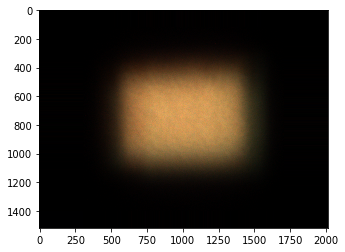

In [16]:
from matplotlib import pyplot as plt
from utils.ops import unpixel_shuffle, rggb_2_rgb

source_rgb = rggb_2_rgb(img).permute(1, 2, 0)
source_rgb = (source_rgb - source_rgb.min()) / (
    source_rgb.max() - source_rgb.min()
)
# Show measurement
plt.imshow(source_rgb.numpy())

# Forward pass
fft_output = FFT(img.unsqueeze(0).float().to(device))
fft_unpixel_shuffled = unpixel_shuffle(fft_output, args.pixelshuffle_ratio)
output_unpixel_shuffled = G(fft_unpixel_shuffled)
output = F.pixel_shuffle(output_unpixel_shuffled, args.pixelshuffle_ratio)

output_numpy = output[0].mul(0.5).add(0.5).permute(1, 2, 0).cpu().detach().numpy()

fft_output_vis = rggb_2_rgb(fft_output.squeeze(0)).mul(0.5).add(0.5)
fft_output_vis = (fft_output_vis - fft_output_vis.min()) / (fft_output_vis.max() - fft_output_vis.min())
fft_output_vis = fft_output_vis.permute(1, 2, 0).cpu().detach().numpy()

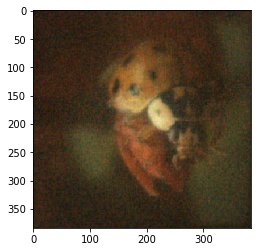

In [17]:
plt.imshow(fft_output_vis)

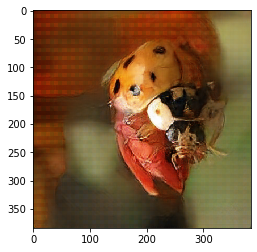

In [18]:
plt.imshow(output_numpy)